In [1]:
## Getting the data

from influxdb import InfluxDBClient # install via "pip install influxdb"
import pandas as pd



In [2]:
client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df

# Get the last 90 days of power generation data
generation = client.query(
    "SELECT * FROM Generation where time > now()-90d Order by time desc"
    ) # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind  = client.query(
    "SELECT * FROM MetForecasts where time > now()-90d and time <= now() and Lead_hours = '1' Order by time desc"
    ) # Query written in InfluxQL

gen_df = get_df(generation).drop(columns=["ANM", "Non-ANM"])
wind_df = get_df(wind).drop(columns=["Lead_hours"])


####################################################


In [9]:
#gen_df.resample('180min').mean()

In [36]:
#new_df = pd.merge(wind_df, gen_df, on=["time"], how="outer").fillna(method='ffill').fillna(method='bfill')
#We make the valid assumption that the windspeed and direction is going to be the same until the next forecast is actual. In the north sea this is a valid assumption (source: I worked offshore in the north sea for 4 years as a Technical Officer Onboard different (PSV) Platform Supply Vessels, along with different SOW's (Service Offshore Wind) vessels, sailed more than 80.000km around that horrible place. Weather providers like YR, can however supply hourly forecasts for weather windows on a paid subscription)


new_df = pd.concat([wind_df, gen_df], axis=1, join='inner').fillna(method='ffill').fillna(method='bfill').dropna()
#Verifies that we got rid of NaN values in our dataset
print(new_df.isna().sum())



Direction      0
Source_time    0
Speed          0
Total          0
dtype: int64


In [13]:
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# #### try with min max scalar##########
# ##### You asked me to give graph for test and predict data ####
# # create an object of the StandardScaler
# scaler = StandardScaler()
# # fit with the Item_MRP
# scaler.fit(np.array(new_df.Speed).reshape(-1,1))
# # transform the data
# new_df.Total = scaler.transform(np.array(new_df.Total).reshape(-1,1))
# new_df.Total


In [37]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset used to plot relationship between variables
Data =new_df[["Speed","Direction", "Total"]]

#If want to look at correlation between wind direction vs. speed, its feasible here to do a manual tranformation of "Direction"-->Radian, because it changes it from String objects to a numeric datatype

Data.replace({"N":math.radians(0), "NNE":math.radians(22.5), "NE":math.radians(45),"ENE":math.radians(67.5),
"E":math.radians(90), "ESE":math.radians(111.5), "SE":math.radians(135), "SSE":math.radians(157.5),"S":math.radians(180),"SSW":math.radians(202.5), "SW":math.radians(225), "WSW":math.radians(247.5), "W":math.radians(270), "WNW":math.radians(292.5),  "NW":math.radians(315),  "NNW":math.radians(337.5)}, inplace=True)

Data.corr().abs()[["Total"]]

new_df.replace({"N":math.radians(0), "NNE":math.radians(22.5), 
"NE":math.radians(45),"ENE":math.radians(67.5),"E":math.radians(90), 
"ESE":math.radians(111.5), "SE":math.radians(135), 
"SSE":math.radians(157.5),"S":math.radians(180),
"SSW":math.radians(202.5), "SW":math.radians(225),
"WSW":math.radians(247.5), "W":math.radians(270),
"WNW":math.radians(292.5),  "NW":math.radians(315), 
"NNW":math.radians(337.5)}, inplace=True)#ZZZzzzzZZZ why do I .... at this???

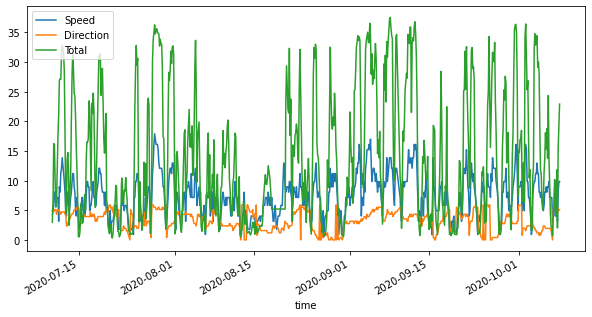

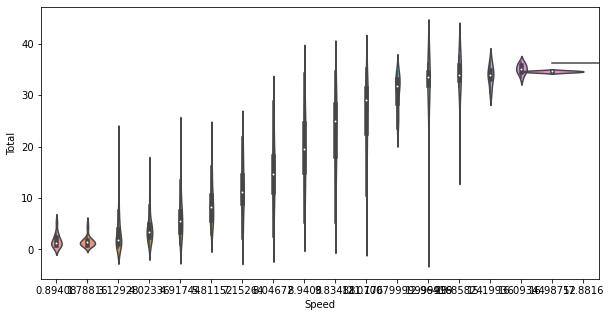

In [38]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

Data.plot()
plt.show()
#The plot confirms the correlation between windspeed and Windpower generation
fig, axs = plt.subplots(figsize=(10,5))
sns.violinplot(x="Speed", y="Total", data=Data, width=2)

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

#new_df["Time"]=new_df.index.values

# Separate target from predictors (Define X and Y)
y = new_df[["Total"]]
X = new_df.drop(['Total'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 20 and X_train_full[cname].dtype == "object"]

print("Categorial columns:"+str(categorical_cols))

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
print("numerical columns:"+str(numerical_cols))

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

#Lets us peek which datatypes are categorial and which are numerical in our integrated schema
print(new_df.info())

Categorial columns:[]
numerical columns:['Direction', 'Source_time', 'Speed']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 708 entries, 2020-10-08 03:00:00+00:00 to 2020-07-10 06:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Direction    708 non-null    float64
 1   Source_time  708 non-null    int64  
 2   Speed        708 non-null    float64
 3   Total        708 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 47.7 KB
None


In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder # changing the string data to categorical data like changing Direction to numbers

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ("Scaler", MinMaxScaler(),["Speed", "Direction"]),
    ],
    remainder = "passthrough")



In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

#model = RandomForestRegressor(n_estimators=100, random_state=15)
model = LinearRegression()
#model = KNeighborsRegressor()
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline([('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Direction', 'Source_time',
                                                   'Speed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('Scaler', MinMaxScaler(),
                                                  ['Speed', 'Direction'])])),
                ('model', LinearRegression())])

MAE: 3.7892224865944137


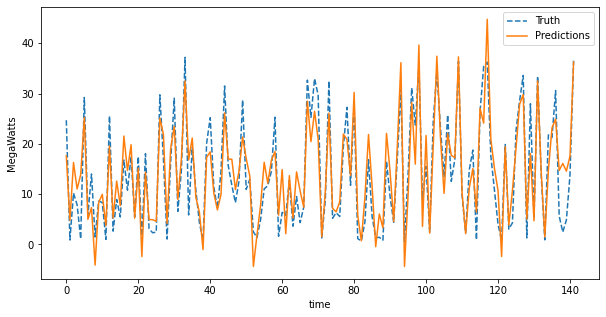

In [44]:
# Preprocessing of validation data, get predictions
#my_pipeline.fit(X_train, y_train)
Y_hat = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, Y_hat)
print('MAE:', score)

X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

plt.plot(X_valid.index, y_valid, "--", label = "Truth")
plt.plot(X_valid.index, Y_hat, label = "Predictions")
plt.xlabel("time")
plt.ylabel("MegaWatts")
plt.legend()
plt.show()



In [13]:
print(X_train.head())

                           Direction   Source_time    Speed
time                                                       
2020-07-14 08:23:00+00:00   5.105088  1.594696e+09  8.04672
2020-09-13 04:07:00+00:00   3.534292  1.599955e+09  3.12928
2020-08-22 21:50:00+00:00   5.105088  1.598119e+09  7.15264
2020-07-13 03:32:00+00:00   3.141593  1.594598e+09  5.81152
2020-08-23 16:06:00+00:00   5.497787  1.598184e+09  5.81152


In [34]:

# Get all future forecasts regardless of lead time
forecasts  = client.query(
    "SELECT * FROM MetForecasts where time > now()"
    ) # Query written in InfluxQL
for_df = get_df(forecasts)
for_df.replace({
    "N":math.radians(0), 
    "NNE":math.radians(22.5), 
    "NE":math.radians(45),
    "ENE":math.radians(67.5),
    "E":math.radians(90), 
    "ESE":math.radians(111.5), 
    "SE":math.radians(135), 
    "SSE":math.radians(157.5),
    "S":math.radians(180), 
    "SSW":math.radians(202.5), 
    "SW":math.radians(225), 
    "WSW":math.radians(247.5), 
    "W":math.radians(270), 
    "WNW":math.radians(292.5), 
    "NW":math.radians(315), 
    "NNW":math.radians(337.5)}, 
    inplace=True)

# Limit to only the newest source time
newest_source_time = for_df["Source_time"].max()
newest_forecasts = for_df.loc[for_df["Source_time"] == newest_source_time].copy()
print(newest_forecasts)

# Preprocess the forecasts and do predictions in one fell swoop 
# using your pipeline


                           Direction Lead_hours  Source_time     Speed
time                                                                  
2020-10-08 06:00:00+00:00   5.105088          2   1602122400   8.94080
2020-10-08 09:00:00+00:00   5.105088          5   1602122400   7.15264
2020-10-08 12:00:00+00:00   4.712389          8   1602122400   7.15264
2020-10-08 15:00:00+00:00   4.712389         11   1602122400   7.15264
2020-10-08 18:00:00+00:00   4.712389         14   1602122400   8.04672
2020-10-08 21:00:00+00:00   4.712389         17   1602122400   5.81152
2020-10-09 00:00:00+00:00   3.534292         20   1602122400   5.81152
2020-10-09 03:00:00+00:00   3.926991         23   1602122400   4.91744
2020-10-09 06:00:00+00:00   5.105088         26   1602122400   4.91744
2020-10-09 09:00:00+00:00   5.105088         29   1602122400   4.91744
2020-10-09 12:00:00+00:00   0.392699         32   1602122400   4.02336
2020-10-09 15:00:00+00:00   5.497787         35   1602122400   4.91744
2020-1

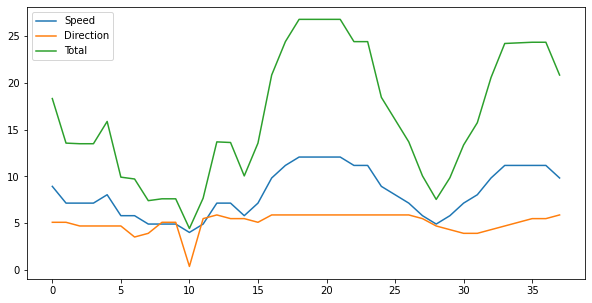

In [35]:
import numpy as np
import pandas as pd

Forecast_new=my_pipeline.predict(newest_forecasts)

# Creating pandas dataframe from ForeCast_new nd array
Forecast_new = pd.DataFrame({'Total': Forecast_new[:, 0]})
newest_forecasts = newest_forecasts.reset_index(drop=True)

Forecast_new = pd.concat([Forecast_new, newest_forecasts], axis=1, join='outer')
Forecast_new = Forecast_new[["Speed","Direction", "Total"]]
Forecast_new.plot()
plt.show()